[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/068_pytorch_profiling/068_pytorch_profiling.ipynb)

# Pytorch - Profiling

En posts anteriores hemos visto mucho ejemplos de lo que podemos llegar a hacer con [Pytorch](https://pytorch.org/), nuestra librería favorita (al menos de momento 😛) para implementar y entrenar redes neuronales. Sin embargo nunca nos hemos preocupado por cómo de óptimo era nuestro código. En este post y los que vienen a continuación nos vamos a enfocar precisamente de ello. 

Para empezar, vamos a reutilizar el código para entrenar una red convolucional en el dataset CIFAR10 que ya hemos usado en posts anteriores. Primero definimos nuestro `Dataset`, que se encargará de leer las imágenes.

In [1]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()
    
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

Files already downloaded and verified
Files already downloaded and verified


A continuación definimos el `DataLoader`, que se encargará de alimentar la red neuronal con `batches` de imágenes.

In [2]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
}

In [3]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

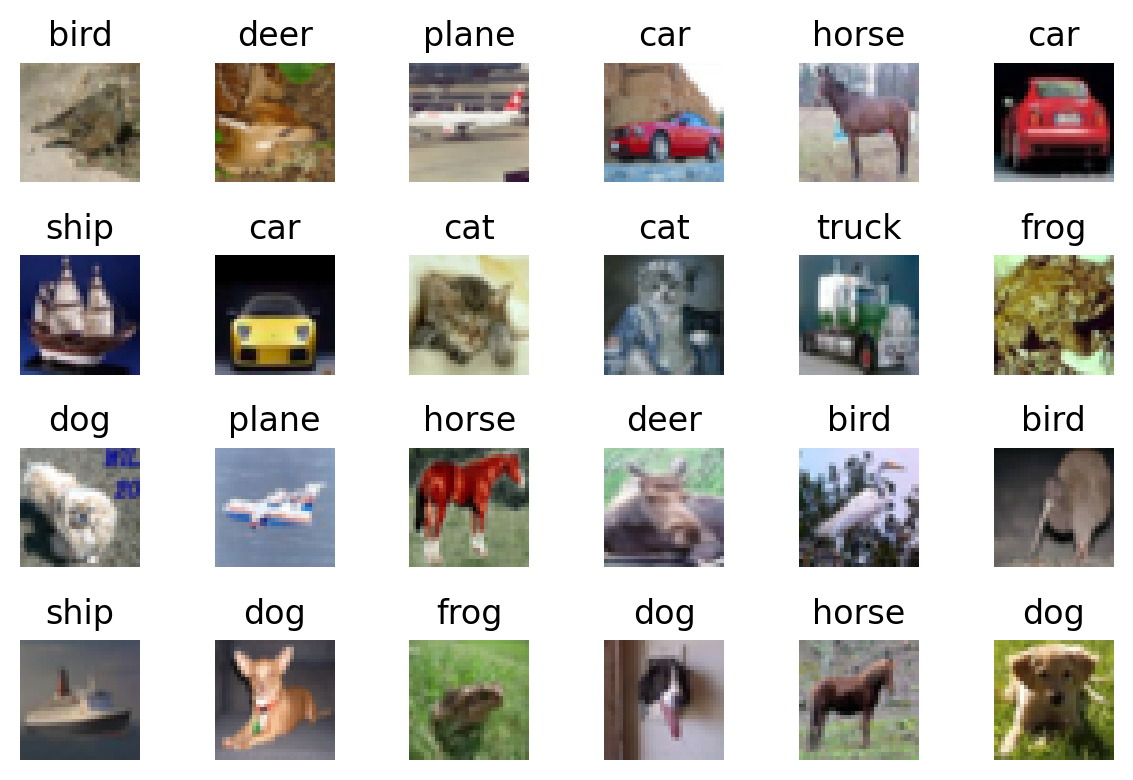

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(ds['train'].classes[label.item()])
        ax.axis('off')
plt.tight_layout()
plt.show()

Usaremos una `resnet18` pre-entranada a la cual cambiaremos la última capa para poder llevar a cabo la tarea de clasificación en 10 clases.

In [5]:
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, n_outputs=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, n_outputs)

    def forward(self, x):
        return self.model(x)

In [6]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

/home/juan/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 10])

A continuación definimos nuestras funciones de entrenamiento.

In [7]:
from tqdm import tqdm

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cpu", prof=None, end=0):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

Finalmente, podemos entrenar nuestro modelo.

In [8]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3)

training... loss 0.9360 acc 0.6875:   0%|          | 3/1563 [00:00<01:16, 20.27it/s]

Epoch 1/3 loss 1.0965 acc 0.6357 test_loss 1.0948 test_acc 0.6170


training... loss 0.5976 acc 0.8047:   0%|          | 3/1563 [00:00<01:16, 20.33it/s]

Epoch 2/3 loss 0.7844 acc 0.7392 test_loss 0.9254 test_acc 0.7219


testing... loss 0.7606 acc 0.7465: 100%|██████████| 313/313 [00:02<00:00, 104.62it/s]

Epoch 3/3 loss 0.6407 acc 0.7841 test_loss 0.7606 test_acc 0.7465


Si bien hemos conseguido nuestro objetivo de entrenar esta red neuronal, ¿acaso lo hemos hecho de la manera más óptima? O dicho de otra manera, ¿sería posible utilizar el hardware que tenemos a nuestra disposición para poder entrenar nuestro modelo más rápido? Para poder responder a estas preguntas necesitamos alguna manera de *trackear* todas las operaciones que tienen lugar durante el entrenamiento y guardar el tiempo o memoria utilizado por cada una de ellas. Para ello podemos usar una herramienta conocida como `Profiler`.

## El `Profiler`

Lo primero que podemos medir es el tiempo que nuestro modelo invierte en cada una de las operaciones involucradas.

> El `profiler` fue introducido en la versión 1.8.1 de `Pytorch`, así que aségurate de tener una versión compatible !

In [9]:
from torch.profiler import profile, record_function, ProfilerActivity

torch.__version__

'1.9.0'

In [10]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(torch.randn(32, 3, 32, 32))

In [11]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        10.05%       1.345ms        99.72%      13.350ms      13.350ms             1  
                     aten::conv2d         0.87%     117.000us        50.98%       6.825ms     341.250us            20  
                aten::convolution         1.06%     142.000us        50.11%       6.708ms     335.400us            20  
               aten::_convolution         1.47%     197.000us        49.05%       6.566ms     328.300us            20  
         aten::mkldnn_convolution        46.50%       6.225ms        47.58%       6.369ms     318.450us            20  
                 aten::batch_norm       

Podemos ver que nuestro modelo se pasa la mayor parte del tiempo calculando convoluciones, y después *batch norm*. Algo importante a remarcar es la diferencia en `Self CPU` y `CPU total`. En el primer caso se calcula el tiempo invertido en el operador, pero no en llamadas a otros operadores, lo cual sí ocurre en el segundo caso.

Podemos agrupar los operadores por tamaños de tensores para obtener más información.

In [12]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference        10.05%       1.345ms        99.72%      13.350ms      13.350ms             1                                                                                []  
                     aten::conv2d         0.24%      32.000us        13.37%       1.790ms     447.500us             4                              [[32, 64, 8, 8], [64, 64, 3, 3], [], [], [], 

Y también visualizar la cantidad de memoria utilizada por el modelo.

In [13]:
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    model(torch.randn(32, 3, 32, 32))
          
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         4.73%     501.000us         4.73%     501.000us       4.912us      12.85 Mb      12.85 Mb           102  
    aten::max_pool2d_with_indices         6.38%     676.000us         6.38%     676.000us     676.000us       1.50 Mb       1.50 Mb             1  
                      aten::addmm         0.39%      41.000us         0.47%      50.000us      50.000us       1.25 Kb       1.25 Kb             1  
              aten::empty_strided         0.06%       6.000us         0.06%       6.000us       6.000us         

## Mejora 1 - Ejección en GPU

Si estas familiarizado con el entrenamiento de redes neuronales, o has seguido un poco la actividad en este blog, no te sorprenderá que la primera mejora que podemos hacer a nuestro código es la de entrenar el modelo en la `GPU`. 

In [14]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3, device="cuda")

training... loss 0.8110 acc 0.7375:   1%|          | 8/1563 [00:00<00:20, 77.22it/s]

Epoch 1/3 loss 1.1147 acc 0.6258 test_loss 0.9054 test_acc 0.7008


training... loss 0.6746 acc 0.7734:   1%|          | 8/1563 [00:00<00:19, 78.86it/s]

Epoch 2/3 loss 0.7732 acc 0.7423 test_loss 0.9249 test_acc 0.6949


testing... loss 0.7883 acc 0.7396: 100%|██████████| 313/313 [00:01<00:00, 270.48it/s]

Epoch 3/3 loss 0.6285 acc 0.7911 test_loss 0.7883 test_acc 0.7396


Podemos ejecutar el `profiler` también en la `GPU` de la siguiente manera.

In [15]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(torch.randn(32, 3, 32, 32).cuda())

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.07%       1.371ms       100.00%        1.877s        1.877s       0.000us         0.00%       1.333ms       1.333ms          -4 b    -384.02 Kb           0 b     -14.31 M

Para poder analizar mejor estos resultados, vamos a exportarlos como archivo `json` y abrirlo en `chrome://tracing/`.

In [16]:
prof.export_chrome_trace("trace.json")

Si bien `Pytorch` nos ofrece herramientas para inspeccionar nuestro modelo, es más probable que quieras evaluar todo tu código de entrenamiento para encontrar posibles cuellos de botella. Esto lo podemos hacer de la siguiente manera.

In [17]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 2.2833 acc 0.2102:   1%|          | 10/1563 [00:07<18:09,  1.43it/s]


El resultado lo podrás encontrar en `./log/resnet18` y podrás visualizarlo con el plugin de `Pytorch` para `Tensorboard`, que además te sugerirá mejoras automáticamente.

> Puedes instalar el plugin con `pip install torch_tb_profiler`

## Mejora 2 - Usar `workers` en el `DataLoader`

Una de las mejoras que nos sugiere es cargar nuestras imágenes en paralelo, lo cual podemos hacer de la siguiente manera.

In [18]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=8)
}

In [19]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_8workers'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 2.3608 acc 0.2330:   1%|          | 10/1563 [00:07<19:19,  1.34it/s]


## Mejora 3 - Aumentar el `batch size`

Otra mejora que nos sugieren es aumentar el `batch size` ya que estamos utilizando nuestra `GPU` muy por debajo de sus posibilidades.

In [20]:
batch_size = 2048

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=8)
}

In [21]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_8workers_2048bs'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 1.3825 acc 0.5273:  40%|████      | 10/25 [00:08<00:12,  1.23it/s]


Con estas mejoras podemos ahora entrenar nuestro modelo.

> Ten en cuenta que usar un `batch size` elevado puede tener consecuencias a la hora de la opimización, es posible que tengas que ajustar el `learning rate` de manera acorde.

In [22]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train(model, dl, optimizer, epochs=10, device="cuda")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/10 loss 1.0400 acc 0.6431 test_loss 0.8615 test_acc 0.7134


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/10 loss 0.5189 acc 0.8206 test_loss 0.6066 test_acc 0.7946


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/10 loss 0.3310 acc 0.8859 test_loss 0.7356 test_acc 0.7715


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/10 loss 0.2164 acc 0.9261 test_loss 0.7175 test_acc 0.7962


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10 loss 0.1427 acc 0.9513 test_loss 0.8073 test_acc 0.7996


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/10 loss 0.1140 acc 0.9615 test_loss 0.9934 test_acc 0.7770


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10 loss 0.0920 acc 0.9682 test_loss 0.9790 test_acc 0.7797


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/10 loss 0.0774 acc 0.9733 test_loss 0.8995 test_acc 0.8040


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10 loss 0.0658 acc 0.9774 test_loss 1.0756 test_acc 0.7755


testing... loss 0.9122 acc 0.8127: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]

Epoch 10/10 loss 0.0603 acc 0.9793 test_loss 0.9122 test_acc 0.8127


Estupendo ! Hemos conseguido reducir el tiempo por *epoch* de 1 minuto y 18 segundos al entrenar en `CPU` a sólo 3 segundos al entrenar en `GPU` de manera óptima (en contra de los 21 segundos sin optimizar) y además obteniendo mejores métricas 🚀

## Resumen

En este post hemos introducido el `Profiler` de `Pytorch`, que nos permite evaluar nuestro código para identificar posibles puntos de mejora. Además, gracias a la integración con `Tensorboard` podemos obtener sugerencias y visualizar todas las operaciones, tanto en `CPU` como en `GPU`. Hemos visto que entranando nuestro modelo en la `GPU`, usando `workers` para cargar imágenes en paralelo en el `DataLoader` y aumentando el `batch size` para aprovechar al máximo la `GPU` nos aportan unas mejoras nada desdeñables. En siguientes posts seguiremos viendo trucos para mejorar todavía más nuestro código.